 ***
 # <font color=red>Using AutoMLx Execution engine</font>
 <p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle AutoMLx Team </font></p>

 ***

 Execution Engine Setup Notebook.

 Copyright © 2024, Oracle and/or its affiliates.

 Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl/

 ## Overview of this Notebook

 In this notebook we will showcase the different options provided by AutoMLx execution engine.

 ## Prerequisites

   - Experience level: intermediate to advanced (Python and Machine Learning)
   - Professional experience: Some industry experience

## Table of Contents

- <a href='#setup'> Engine configuration</a>
    - <a href='#modules'> Imported modules</a>
    - <a href='#default-setup'> Default engine setup</a>
    - <a href='#custom-setup'> Custom setup for all engine types</a>
- <a href='#ray'> Ray Engine</a>
    - <a href='#ray-conf'> Configuring the Ray Engine</a>
    - <a href='#mult-ray'> Multi-node Ray cluster</a>
        - <a href='#utils-ray'> Creating a Ray cluster through AutoMLX's utils</a>
        - <a href='#manual-ray'> Creating a Ray cluster manually</a>
        - <a href='#auto-ray'> Creating a Ray cluster through the launcher</a>
        - <a href='#TLS-ray'> Manual TLS authentication setup</a>
        - <a href='#automlx-ray'> Connecting AutoMLx backend to an existing Ray cluster </a>
        - <a href='#stopping-ray'> Stopping the Ray cluster </a>
- <a href='#multiproc'> Multiprocessing Engine</a>
- <a href='#threading'> Multithreading Engine</a>
- <a href='#differences'> Differences between engines </a>
- <a href='#refs'> References </a>

 <a id='setup'></a>
# Engine configuration
The AutoMLx package is compatible with multiple distributed execution engines. This section will showcase how to start an AutoMLx engine instance with default and custom configurations.


<a id='modules'></a>
## Imported modules
Note that all of the engine operations imports here are fully optional, as the engine will be initialized and shutdown with default settings if these methods are not used.

In [ ]:
# To run some example classification task with AutoMLx
from tempfile import TemporaryDirectory
from pathlib import Path

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Code for engine operations
from automlx import Pipeline, init, shutdown
from automlx._backend.utils import (
    TLSConfig,
    initialize_ray_head_node,
    initialize_ray_worker_node,
    stop_ray_cluster,
)

 <a id='default-setup'></a>
## Default engine setup
The AutoMLx package offers the function `init` to initialize the parallelization engine.
This method can be used to manually setup the engine options.
However, if not used, AutoMLx will automatically setup the engine with default options as soon as it is needed.
At the end of an AutoMLx Pipeline, `shutdown` can be called to reset the parallelization engine. If not manually called, the Engine will stay alive until the python executable finishes, or a SIGKILL is sent (this happens when the program is forcefully terminated).
This means it is generally not needed to manually call `shutdown`.

[Ray](https://docs.ray.io/en/latest/index.html) is the default execution backend for AutoMLx, It provides the compute layer for parallel processing.
It is an open source project that makes it simple to scale any compute-intensive Python workload.

In case of the Ray engine, AutoMLx offers both multi-node and single-node (local cluster) options.
With "local cluster" we mean a cluster of worker threads within the same compute node that asynchronously use the available CPU cores.
On the other hand, by "multi-node" we mean a cluster of worker threads belonging to multiple separate nodes that can interact with a single head node via Ray to schedule tasks.
By default, AutoMLx starts a local cluster Ray Engine that has access to all the CPUs and GPUs available in the current machine.


In [ ]:
# Example classification pipeline
dataset = fetch_openml(name="adult", version=1, as_frame=True)
df, y = dataset.data, dataset.target

# Several of the columns are incorrectly labeled as category type in the original dataset
numeric_columns = ["age", "capitalgain", "capitalloss", "hoursperweek"]
for col in df.columns:
    if col in numeric_columns:
        df[col] = df[col].astype(int)


X_train, X_test, y_train, y_test = train_test_split(
    df, y.map({">50K": 1, "<=50K": 0}).astype(int), train_size=0.7, random_state=0
)

est1 = Pipeline(task="classification")
est1.fit(X_train, y_train)

shutdown()

 <a id='custom-setup'></a>
## Custom setup for all engine types
The `engine` parameter of `init` can accept three values (`ray` which is the default, `local` for multiprocessing, and `threading`) to match the three execution engines offered by AutoMLx.

The `init` function can also customize the resources used by the individual trials through the following parameters:
- `n_jobs` : Specifies the number of parallel Jobs that AutoMLx can run concurrently
- `model_n_jobs` : Specifies the number of cores used by every Job to train a model

For example, if you have a node where you want to preserve half the CPU cores for some orthogonal tasks (e.g., https server),
you may limit AutoMLx to a certain number of nodes: if we have 10 virtual CPUs (Intel Hyper-threading or AMD SMT enabled) but want to run at most 5 Jobs using 1 core each, we can set `n_jobs` to 5 and `model_n_jobs` to 1.

In [ ]:
init(engine_opts={"n_jobs": 5, "model_n_jobs": 1})

 <a id='ray'></a>
 # Ray Engine
This section explains how to use AutoMLx to start a local cluster and how to start a multi-node ray cluster and connect AutoMLx Engine to it.

 <a id='ray-conf'></a>
 ## Configuring the Ray Engine
The cluster configuration can be customized through the `ray_setup` parameter.
`ray_setup` is a dictionary that specifies all the options to be passed to [`ray.init`](https://docs.ray.io/en/latest/ray-core/api/doc/ray.init.html).
For instance, it can be used to disable the dashboard, a useful web application showing a bird's eye view of what is happening in each worker.
The dashboard is active by default, but since it requires resources and occupies an additional port, in some cases the user might want to disable it.
In this example, we start a local Ray cluster limited to one CPU of the current machine, and with the dashboard disabled.
Note that Ray does not constrain execution to happen in the specified resources, but uses resource specification only for scheduling. For instance, specifying
5 CPUs to be used will not guarantee that only 5 CPUs are used; instead, it guarantees that Ray will limit the number of concurrent tasks to ensure that the sum of CPUs specified for all tasks does not exceed 5.

In [ ]:
init(engine_opts={"ray_setup": {"num_cpus": 1, "include_dashboard": False}})

 <a id='mult-ray'></a>
 ## Multi-node Ray cluster
This section will show how to start a custom multi-node ray cluster and configure it properly.

Generally, a multi-node cluster will prove useful when there's the need for more parallelization than what a single machine can provide.
Moreover, several AutoMLx instances running on different machines will be able to connect to the same multi-node cluster and participate in the same
scheduling of resources.

A multi-node Ray cluster can be started in different modalities, but we recommend using AutoMLx's utils to do so,
as they wrap the Ray commands in a straightforward and intuitive manner, especially for what concerns setting up TLS.
Ray needs a `head` node to which the several `worker` nodes can be connected.
The head node needs to be setup first, and needs to be reachable from all of the worker nodes and viceversa.
Moreover, Ray will open up several ports, some of which are customizable, while others are always chosen at random between the open ones. All the used ports
need to be open. The default ports can be found [here](https://docs.ray.io/en/latest/ray-core/configure.html#ports-configurations).
After setting up the cluster, AutoMLx can connect to it through the `init` method from whichever node belongs to it (either head or workers).

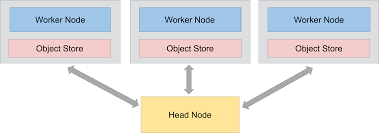

 <a id='utils-ray'></a>
 ### Creating a Ray cluster through utils provided by AutoMLx
AutoMLx provides utils that wrap the Ray cluster setup. In particular, it allows for the initialization of the `head` node and `worker` nodes.
To begin, from a shell in the head node, run the following command to set up the Ray Engine with default settings and ports. Refer to documentation of the method to explore customization options.

In [ ]:
temp_directory = TemporaryDirectory(dir=str(Path.cwd())).name
head_ip = initialize_ray_head_node(temp_dir=temp_directory)

The following action will be to run this method on each of the worker nodes:

In [ ]:
initialize_ray_worker_node(head_address=head_ip, temp_dir=temp_directory)

This will initialize the worker node by connecting to the IP address and default port (6379, can be changed) to the head node.

Ray also offers the capability to setup a TLS connection between its `gRPC` channels (https://docs.ray.io/en/latest/ray-core/configure.html#tls-authentication).
gRPC is a Remote Procedure Call protocol used by Ray to allow the workers to communicate, and TLS (Transport Layer Security) will allow the exchanged messages to be encrypted to avoid malicious agents to eavesdrop on the communications.
Establishing end-to-end security of data is optional but may offer secure communication in-between cluster nodes, often at an insignificant overhead to running time. We provide utilities to quickly create a TLSConfig as follows:

In [ ]:
node_certificate_location = "placeholder.crt"
node_private_key_location = "placeholder.key"
certification_authority_certificate_location = "placeholder.crt"
tls_conf = TLSConfig(
    node_certificate_location,
    node_private_key_location,
    certification_authority_certificate_location,
)

TLSConfig or TLS connection requires several certificates and key files. The certificate issued by the certification authority will need to be in each of the nodes.
Ray offers some [scripts that can be used as reference for generating these files](https://raw.githubusercontent.com/ray-project/ray/master/doc/source/cluster/kubernetes/configs/static-ray-cluster.tls.yaml).
You can refer to the `gencert_head` and `gencert_worker` shell scripts. These are designed for Linux systems.
Note that creating keys and certificates will usually require sudo rights.
To finish your TLS Cluster setup, you need to run the previous methods with the TLSConfig as a parameter.
In the head node:

In [ ]:
head_ip = initialize_ray_head_node(tls_config=tls_conf, temp_dir=temp_directory)

In the worker nodes:

In [ ]:
initialize_ray_worker_node(head_address=head_ip, tls_config=tls_conf, temp_dir=temp_directory)

 <a id='manual-ray'></a>
 ### Creating a Ray cluster manually
A Ray cluster can be also started through Command Line Interface using the following commands:
- `ray start --head --port=<HEAD_PORT>` : This command has to be run on the head node
- `ray start --address=<head-node-address:HEAD_PORT>` : This command has to be run on the worker nodes

The ray cluster can be later shutdown by running  `ray stop` on every node.

More information on how to setup a cluster manually can be found [here](https://docs.ray.io/en/latest/cluster/vms/user-guides/launching-clusters/on-premises.html#manually-set-up-a-ray-cluster)


 <a id='auto-ray'></a>
 ### Creating a Ray cluster manually through the launcher
A Ray cluster can also be created in an Automated way from any machine using a YAML config file.

`ray attach <YAML_FILE_PATH>` can be used to start the cluster and setup the head node and its workers.

The cluster can then be torn down using `ray down <YAML_FILE_PATH>`.

An example config file can be found [here](https://github.com/ray-project/ray/tree/eacc763c84d47c9c5b86b26a32fd62c685be84e6/python/ray/autoscaler/local/example-full.yaml).

A more detailed explanation on the cluster setup can also be found in the [official ray documentation website](https://docs.ray.io/en/latest/cluster/vms/user-guides/launching-clusters/on-premises.html#start-ray-with-the-ray-cluster-launcher)


 <a id='tls-ray'></a>
 ### Manual TLS authentication setup
Instead of using AutoMLx's utils for TLS setup, you can also set it up manually.
TLS authentication can only be used before the Ray cluster is started by specifying the following environmental variables:
- `RAY_USE_TLS`: Either 1 or 0 to use/not-use TLS. If this is set to 1 then all of the environment variables below must be set. Default: 0.
- `RAY_TLS_SERVER_CERT`: Location of a certificate file (tls.crt), which is presented to other endpoints to achieve mutual authentication.
- `RAY_TLS_SERVER_KEY`: Location of a private key file (tls.key) for the current node, which is the cryptographic means to prove to other endpoints that you are the authorized user of a given certificate.
- `RAY_TLS_CA_CERT`: Location of a CA certificate file (ca.crt) present in all nodes, which allows TLS to decide whether an endpoint’s certificate has been signed by the correct authority.

More information can be found [here](https://docs.ray.io/en/latest/ray-core/configure.html#tls-authentication)

 <a id='automlx-ray'></a>

### Connecting AutoMLx backend to an existing Ray cluster

Finally, regardless of how the cluster was created, you will be able to connect to it by initializing the engine with the `cluster_mode` option set to True:

In [ ]:
init(engine_opts={"cluster_mode": True, "ray_setup": {"_temp_dir": temp_directory}})

Ray will autodetect the running cluster and connect to it.
Note that this can be done from any of the nodes in the cluster (not necessarily the head node) as all of the nodes will be able to schedule tasks
across all of the available cluster resources.

 <a id='stopping-ray'></a>

### Stopping the Ray cluster

In the case of the Ray engine, the local Ray instance will be automatically stopped at the end of the Python execution.
However, in the case of multi-node execution, all of the nodes will need to stop the cluster in order to successfully clear it (see <a href='#stopping-ray'> Stopping the Ray cluster </a>).
To do so, you can run this method on each of the nodes:

In [ ]:
stop_ray_cluster()

Or `ray stop --force` from your terminal, again on each of the nodes.

 <a id='multiproc'></a>
## Multiprocessing Engine
To use AutoMlx with Python Multiprocessing, we need to pass the `engine="local"` parameter to the `init` function.

In [ ]:
init(engine="local")

 <a id='threading'></a>
## Threading Engine
To use AutoMLx with Python threading, we need to pass the `engine="threading"` parameter to the `init` function.

In [ ]:
init(engine="threading")

<a id='differences'></a>
## Differences between Execution Engines
Be aware that engines other than Ray cannot achieve multi-node execution and are generally slower than the Ray one.
On average, Ray will be faster than Multiprocessing, which is in turn faster than threading.
Note that the multi-threading engine is confined by the Global Interpreter Lock (GIL) of the Python language, and hence cannot use more than two threads (i.e. one CPU) for its compute. This backend however might be suitable for prediction service deployments in production containers
as it does not require file writes to disk (such as those needed by Ray and multiprocessing to escape the GIL).
Using the multiprocessing and threading engines might be suitable for single-node executions with low levels of parallelization (that is, a few concurrent tasks).
Moreover, Ray is the only engine that supports distributed training.
Thus, Ray is generally the recommended engine for AutoMLx.

<a id='ref'></a>
## References
* Oracle AutoML: http://www.vldb.org/pvldb/vol13/p3166-yakovlev.pdf
* Ray configuration page: https://docs.ray.io/en/latest/ray-core/configure.html